In [231]:
import pandas as pd
import numpy as np
from numpy import mean
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [196]:
df = pd.read_csv('data.csv')

In [197]:
def calError(row):
    if row['TOTAL'] == 0:
        val = 0
    else:
        val = (row['QTYERROR'] / row['TOTAL']) * 100
    return val

df['TOTAL'] =  df[['QTYERROR', 'QTYGOOD']].sum(axis=1)
df['ERROR_RATE'] = df.apply(calError, axis=1)
df.loc[:, ('WORKER')] = df['WORKER'].astype(str)
df.loc[:, ('WrkCtrID')] = df['WrkCtrID'].astype(str)
df['TIME_DEVIATION'] = df['CalcHours'] - df['Hours']

In [198]:
df.nunique()

ProdId            241
ITEMID             19
OprID              23
WORKER             15
WrkCtrID           34
CalcHours         282
Amount            245
Hours             221
QTYERROR            2
QTYGOOD            52
TOTAL              52
ERROR_RATE          5
TIME_DEVIATION    280
dtype: int64

In [199]:
df['ERROR_RATE'].unique()

array([  0.        ,  14.28571429,  16.66666667, 100.        ,
         5.88235294])

In [200]:
Counter(df['ERROR_RATE'])

Counter({0.0: 1091,
         14.285714285714285: 1,
         16.666666666666664: 2,
         100.0: 1,
         5.88235294117647: 1})

In [201]:
df.describe()

,CalcHours,Amount,Hours,QTYERROR,QTYGOOD,TOTAL,ERROR_RATE,TIME_DEVIATION
count,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000
mean,15.030301,81.919480,17.542772,0.004562,42.397810,42.402372,0.140056,-2.512471
std,54.245213,602.494361,111.283641,0.067419,243.659813,243.659148,3.136578,95.180171
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1623.903326
25%,0.666666,2.330000,0.360720,0.000000,0.000000,0.000000,0.000000,0.102345
50%,2.000000,6.670000,1.000000,0.000000,5.000000,5.000000,0.000000,0.684033
75%,8.000000,18.640000,4.000000,0.000000,18.000000,18.000000,0.000000,2.000000
max,600.000000,11120.000000,1869.236667,1.000000,3063.000000,3063.000000,100.000000,306.912600


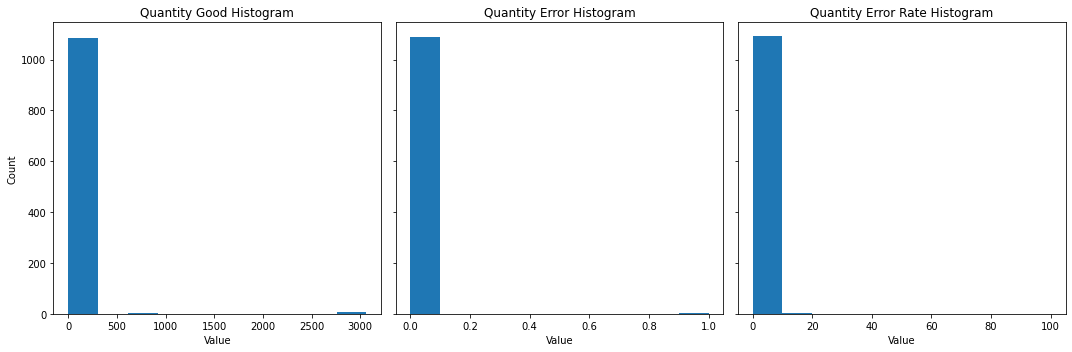

In [202]:
n_bins=10

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(15,5))
for i in range(3):
    axs[i].set_xlabel('Value')

axs[0].set_ylabel('Count')
axs[0].hist(df['QTYGOOD'], bins=n_bins)
axs[0].set_title('Quantity Good Histogram')
axs[1].hist(df['QTYERROR'], bins=n_bins)
axs[1].set_title('Quantity Error Histogram')
axs[2].hist(df['ERROR_RATE'], bins=n_bins)
axs[2].set_title('Quantity Error Rate Histogram')
plt.show()

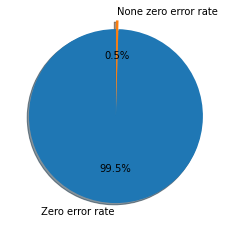

In [203]:
errorRateZero, errorRateNoneZero = 0, 0
for key, val in Counter(df['ERROR_RATE']).items():
    if key == 0:
        errorRateZero += val
    else:
        errorRateNoneZero += val

plt.pie([errorRateZero, errorRateNoneZero], labels=['Zero error rate', 'None zero error rate'], explode=[0,0.1], autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()

In [204]:
def plotCategory(field):
    items = df[field].value_counts()
    plt.figure(figsize=(15, 5))
    plt.bar(items.keys(), items.values)
    plt.xticks(rotation=45)
    plt.show()

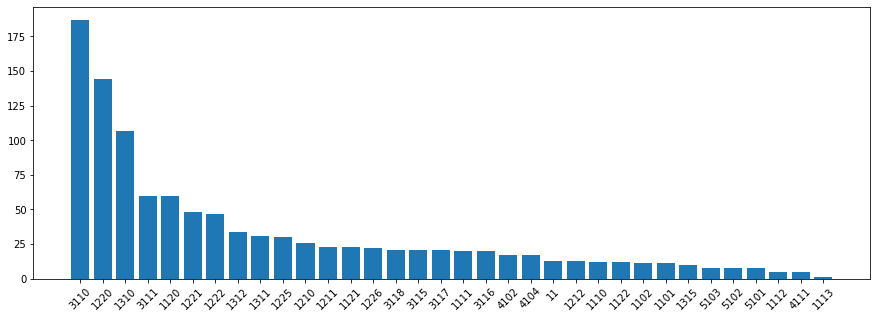

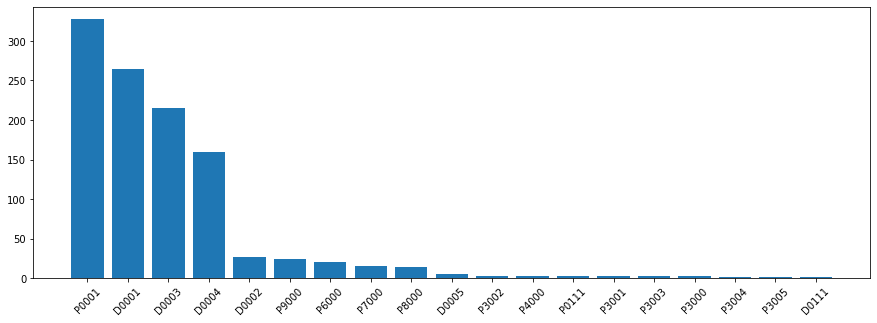

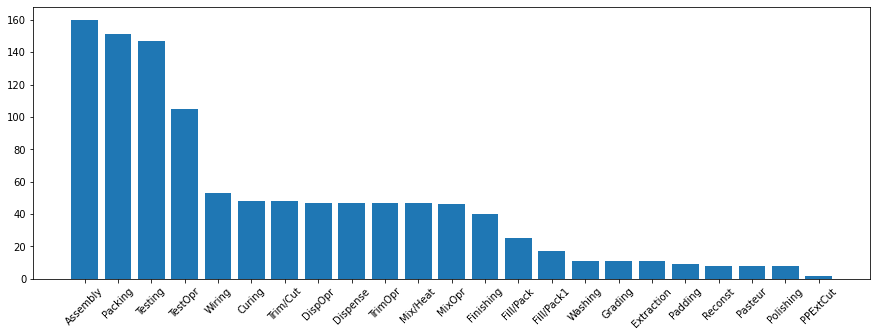

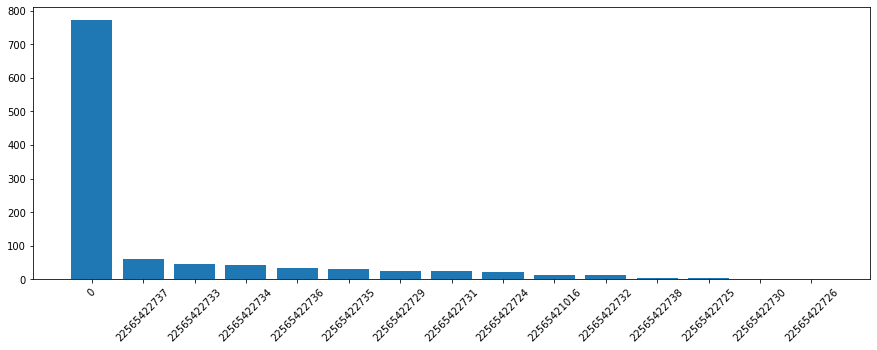

In [205]:
plotCategory('WrkCtrID')
plotCategory('ITEMID')
plotCategory('OprID')
plotCategory('WORKER')

# Preprocessing and feature engineering

In [206]:
features = ['ITEMID', 'OprID', 'WORKER', 'WrkCtrID']
data = df.loc[:, features]
data.loc[:, ('WORKER')] = data['WORKER'].astype(str)
data.loc[:, ('WrkCtrID')] = data['WrkCtrID'].astype(str)
# X = data.to_numpy()
X = data.loc[:]
# y = df['ERROR_RATE'].astype(str)
data['ERROR_GROUP'] = np.where(df.ERROR_RATE > 0, True, False)
y = data['ERROR_GROUP'].astype(str)

In [207]:
Counter(y)

Counter({'False': 1091, 'True': 5})

In [208]:
def getMajorityClass(d):
    max_ = -1
    majority = None
    for key, val in d.items():
        if val > max_:
            majority = key
            max_ = val
    return majority

In [209]:
labelDict = Counter(y)
overSampleRate = 0.5
maj = getMajorityClass(labelDict)
majorityCount = labelDict[maj]
sampleDict = {key: int(overSampleRate * majorityCount) for key in labelDict.keys() if key != maj}
classWeight = {key: 2 for key in labelDict.keys() if key != maj}
classWeight[maj] = 1

In [210]:
enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
over = SMOTE(sampling_strategy=sampleDict, random_state=42, k_neighbors=3)
under = RandomUnderSampler(sampling_strategy='majority')
# model = DecisionTreeClassifier(random_state=0)
model = RandomForestClassifier(random_state=42, class_weight=classWeight)
steps = [('encoding', enc), ('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)
X_res, y_res = pipeline.fit_resample(X, y)

# Training and validating

In [211]:
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_res, y_res, cv=cv, n_jobs=-1)
print('cross_val_score: %.3f' % mean(scores))

cross_val_score: 0.985


In [212]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, random_state=0)
model.fit(X_train, y_train)
print('Score for train data', model.score(X_train, y_train))
print('Score for test data', model.score(X_test, y_test))

Score for train data 0.9877600979192166
Score for test data 0.9853479853479854


In [213]:
Counter(y_test)

Counter({'True': 154, 'False': 119})

# Feature importance

## Decision Tree feature importance

<ipython-input-214-76756d740c97>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names[sorted_idx])


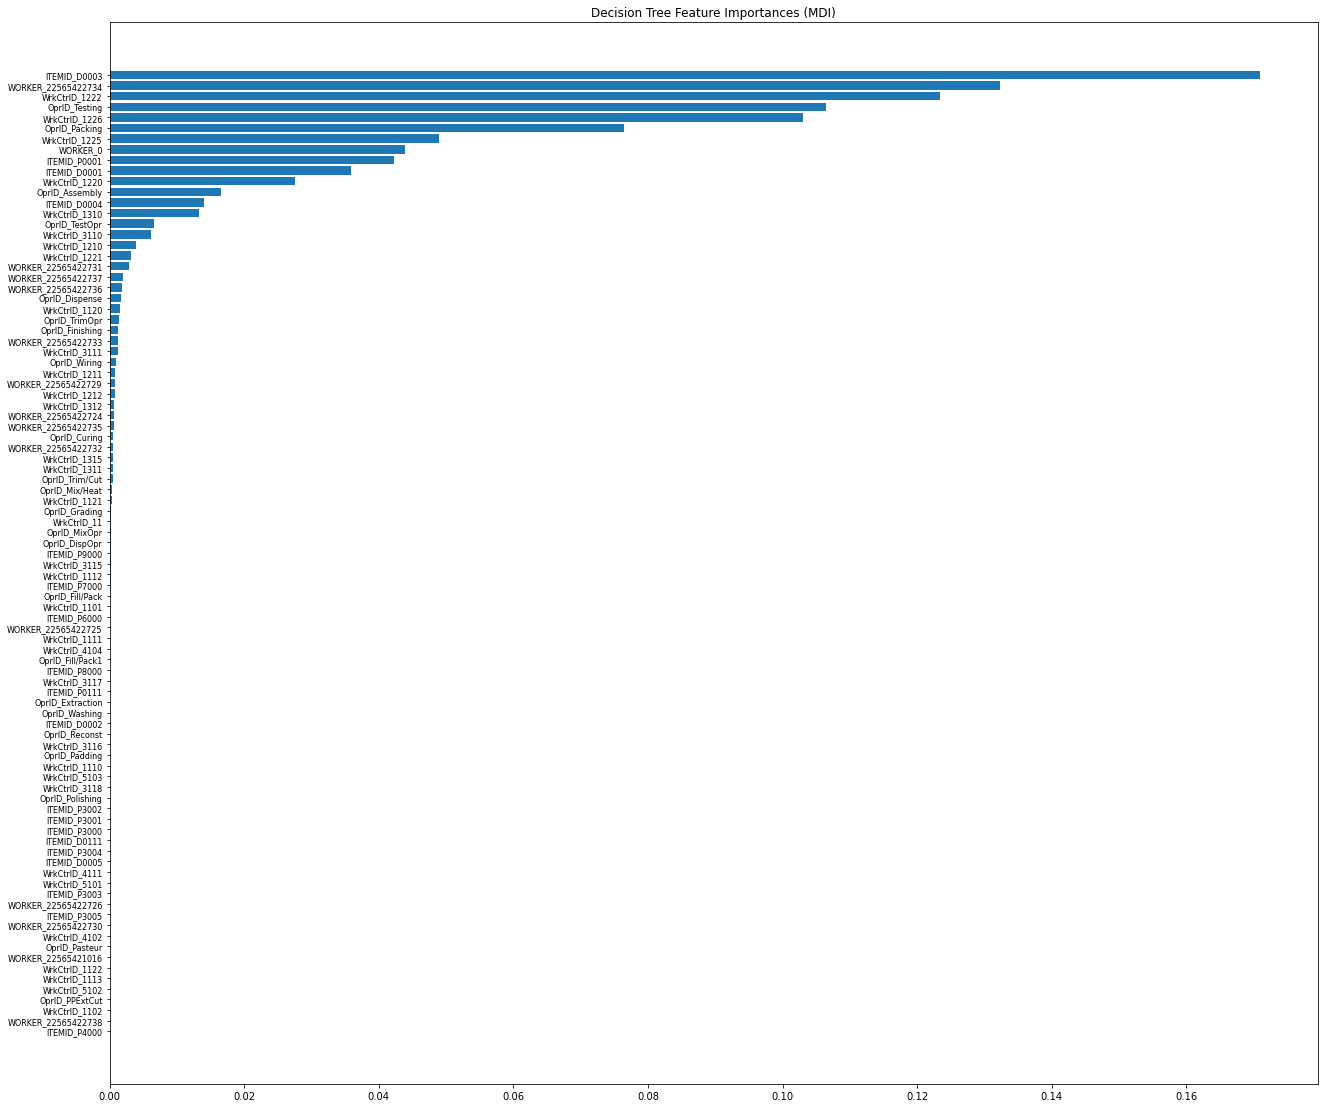

In [214]:
feature_names = pipeline.named_steps['encoding'].get_feature_names(list(X.columns))
tree_feature_importances = (model.feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Decision Tree Feature Importances (MDI)")
fig.set_size_inches(18.5, 15.5)
plt.tick_params(axis='y', which='major', labelsize=8)
fig.tight_layout()
plt.show()

## Permutation feature importance

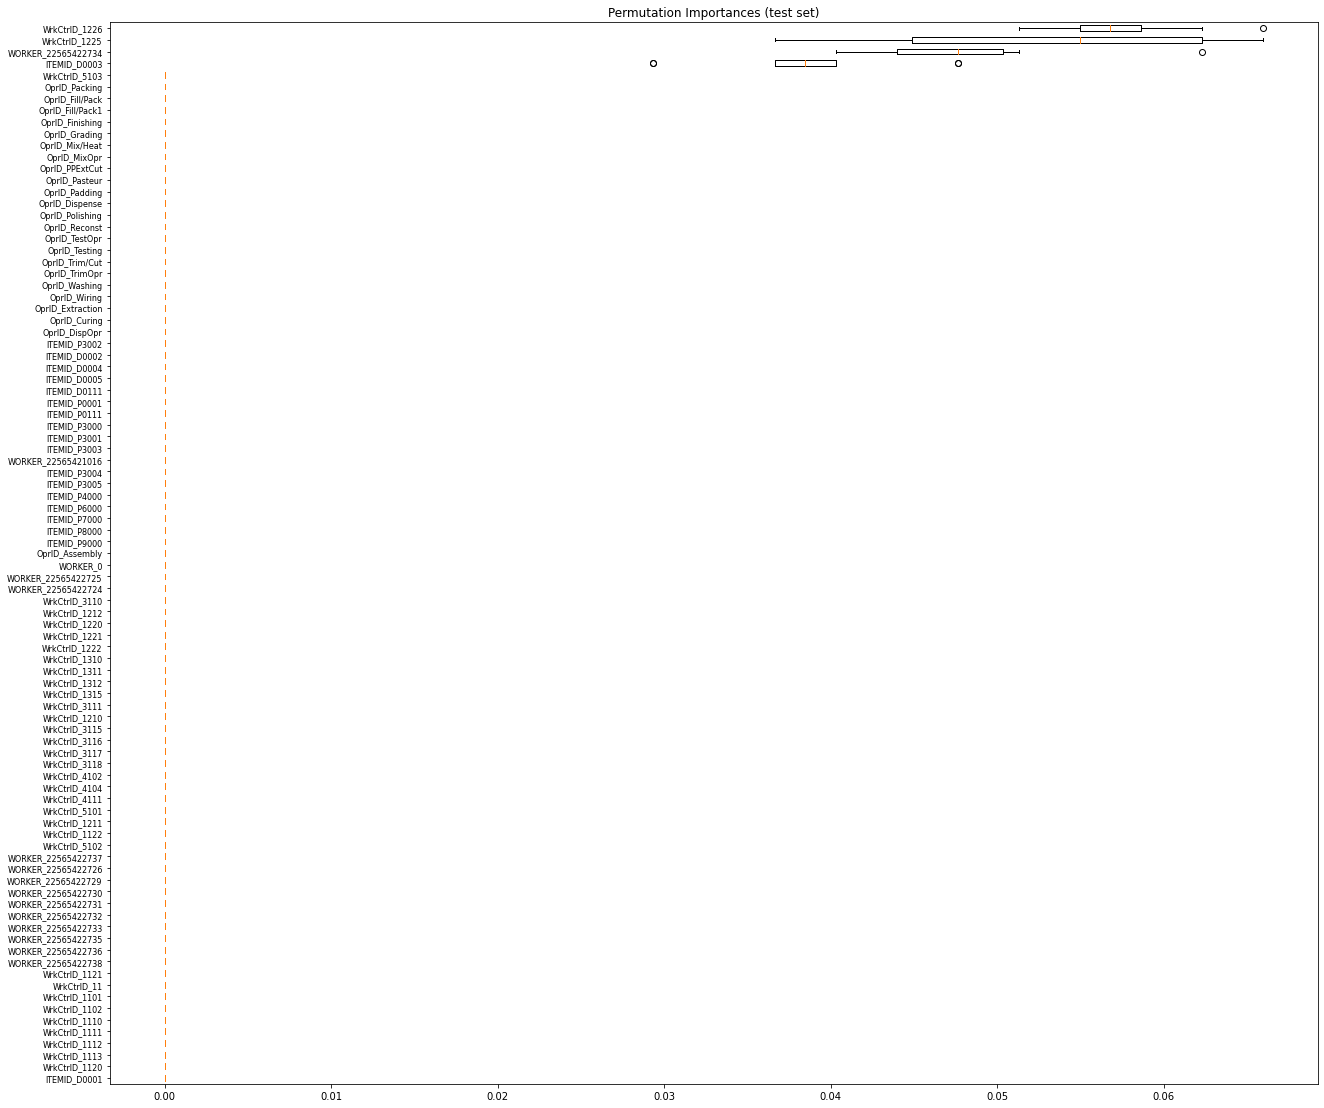

In [215]:
result = permutation_importance(model, X_test.todense(), y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=feature_names[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.set_size_inches(18.5, 15.5)
plt.tick_params(axis='y', which='major', labelsize=8)
fig.tight_layout()
plt.show()

## Multicollinear Features

In [216]:
# Select features that contribute to the model
X_res_df = pd.DataFrame(X_res.toarray(), columns = feature_names)
# selected_features = [item[1] for item in zip(tree_feature_importances[sorted_idx], feature_names[sorted_idx]) if item[0] != 0]
selected_features = feature_names[sorted_idx][-10:]
X_res_selected = X_res_df.loc[:, selected_features]

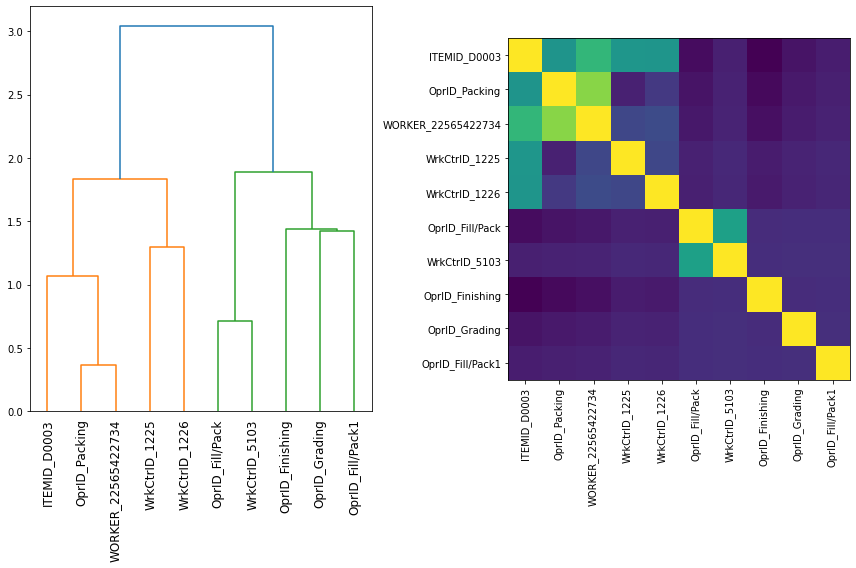

In [217]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X_res_selected).correlation
corr_linkage = hierarchy.ward(np.nan_to_num(corr))
dendro = hierarchy.dendrogram(
    corr_linkage, labels=list(selected_features), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

# Time Usage Deviation

In [224]:
features = ['ITEMID', 'OprID', 'WORKER', 'WrkCtrID']
data = df.loc[:, features]
data.loc[:, ('WORKER')] = data['WORKER'].astype(str)
data.loc[:, ('WrkCtrID')] = data['WrkCtrID'].astype(str)
X = data.loc[:]
y = df['TIME_DEVIATION']

In [244]:
regr = svm.SVR()
steps = [('encoding', enc), ('model', regr)]
pipeline = Pipeline(steps=steps)
# pipeline.fit(X, y)

In [ ]:
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# scores = cross_validate(pipeline, X, y, cv=cv, n_jobs=-1)
# print('cross_val_score: %.3f' % mean(scores))

In [245]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
pipeline.fit(X_train, y_train)
print('Score for train data', pipeline.score(X_train, y_train))
print('Score for test data', pipeline.score(X_test, y_test))

Score for train data 0.005761260561820358
Score for test data 0.009055415294398572


(array([   3.,    0.,    0.,    0.,    0.,    0.,   11.,    3., 1068.,
          11.]),
 array([-1623.903326 , -1430.8217334, -1237.7401408, -1044.6585482,
         -851.5769556,  -658.495363 ,  -465.4137704,  -272.3321778,
          -79.2505852,   113.8310074,   306.9126   ]),
 <BarContainer object of 10 artists>)

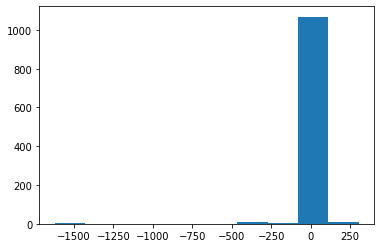

In [252]:
plt.hist(y)

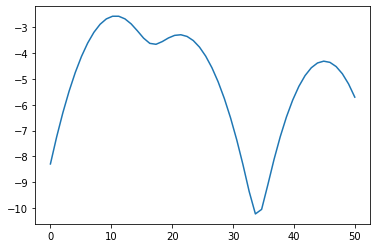

In [254]:
from numpy import array, linspace
from sklearn.neighbors import KernelDensity

a = array([10,11,9,23,21,11,45,20,11,12]).reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(a)
s = linspace(0,50)
e = kde.score_samples(s.reshape(-1,1))
plt.plot(s, e)

In [271]:
argrelextrema(e, np.less)

(array([17, 33], dtype=int64),)

In [259]:
from scipy.signal import argrelextrema
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
print("Minima:", s[mi])
print("Maxima:", s[ma])
print(a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]])

Minima: [17.34693878 33.67346939]
Maxima: [10.20408163 21.42857143 44.89795918]
[10 11  9 11 11 12] [23 21 20] [45]


(array([   3.,    0.,    0.,    0.,    0.,    0.,   11.,    3., 1068.,
          11.]),
 array([-1623.903326 , -1430.8217334, -1237.7401408, -1044.6585482,
         -851.5769556,  -658.495363 ,  -465.4137704,  -272.3321778,
          -79.2505852,   113.8310074,   306.9126   ]),
 <BarContainer object of 10 artists>)

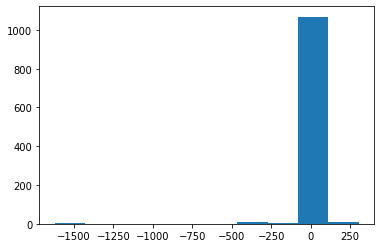

In [260]:
plt.hist(y)